In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.EnvironmentBasics import Environment, Action, State
from utils.GridWorld import GridWorld
from utils.AgentBasics import Agent, Policy
from tqdm import tqdm
from utils.GridWorldPitfalls import GridWorldWithPitfalls
from typing import *

# Off-Policy
一个最优的policy在每一步中只会指引agent选择最优的action，但为了exploration，我们需要一个exploration policy，这个policy会指引agent选择一些不是最优的action。这个exploration policy和最优的policy是不同的，但是我们希望最终的policy能够逼近最优的policy。<p>
$q_{\pi}(s, a)$ 为target policy $\pi(s)$ 的action-value function，随机初始化，$\pi(s)$永远greedy<p>
$c(s, a)$ 为state s和action a的权重，全0初始化<p>
$W$ 为采样权重，$W = \frac{\pi(s, a)}{b(s, a)}$，每次episode结束更新参数前，初始化为1，随着从后往前循环episode的每一项，它会逐渐变小。<p>
$b(s)$是exploration policy，不greedy，可以 $ \epsilon - greedy$，生成episode时用这个policy，但是不更新它<p>
$$c_{b}(s, a) \leftarrow c_{b}(s, a) + W$$
上面的式子是为了更新每个state和action的权重，这个权重是用来计算target policy的action-value function的。每次visit都会使这个权重增加。<p>
$$q_{\pi}(s, a) \leftarrow q_{\pi}(s, a) + \frac{W}{c(s, a)}(G - q_{\pi}(s, a))$$
上面的式子是为了更新target policy的action-value function，随着从后往前循环episode，W变小，c(s, a)变大，因此在episode中越靠前的state-action pair更新得就越小，越靠后更新得越多。<p>
$$ W \leftarrow W \frac{\pi(s, a)}{b(s, a)}$$

Monte Carlo (Every Visit & Off-Policy): 100%|██████████| 2000/2000 [00:01<00:00, 1127.25it/s]


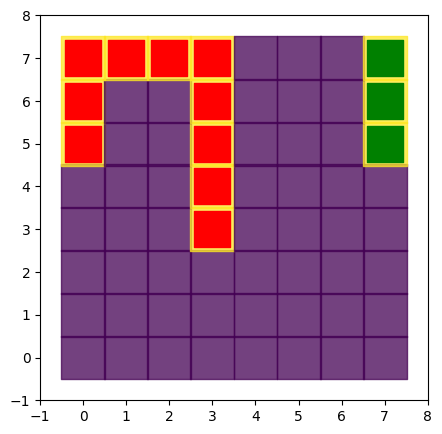

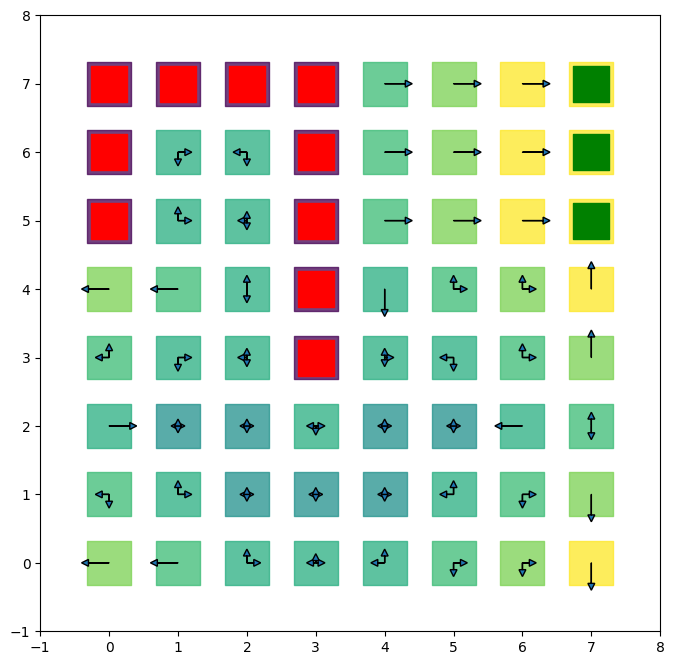

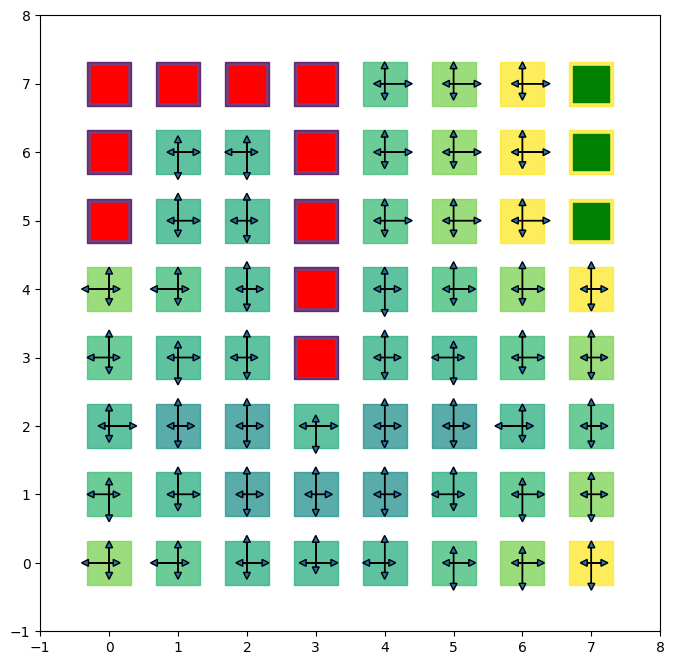

In [3]:
def OffPolicyMC(grid_world: GridWorldWithPitfalls):
    agent = Agent(grid_world, Policy(grid_world))
    # Make state value of terminal state
    agent.initTerminalValues(grid_world)
    gamma = 0.6

    grid_world.render()

    # agent.policy is the behavior policy
    # this is the target policy
    target_policy = Policy(grid_world)

    # Monte Carlo (Every Visit & Off-Policy)
    state_action_weights = np.zeros((grid_world.n_states, grid_world.n_actions))
    for it in tqdm(range(2000), desc="Monte Carlo (Every Visit & Off-Policy)"):
        # Generate episode
        grid_world.reset()  # reset with a random start state
        episode_states = [grid_world.start_sid]
        episode_actions = []
        episode_rewards = []

        while not grid_world.isTerminalState(grid_world.current_sid):
            random_action_id = agent.takeAction(grid_world.current_sid, epsilon=0.3)
            # random_action_id = np.random.randint(0, grid_world.n_actions)
            episode_actions.append(random_action_id)
            reward = grid_world.step(random_action_id)
            episode_rewards.append(reward)
            episode_states.append(grid_world.current_sid)
        episode_states = episode_states[:-1]  # remove the last state, which is terminal state


        # Loop state backward to update state value
        W = 1
        G = 0
        for t in range(len(episode_states)-1, -1, -1):
            G = gamma * G + episode_rewards[t]

            state_id = episode_states[t]
            action_id = episode_actions[t]
            state_action_weights[state_id, action_id] += W
            # Update state value (no need to update state value)
            # agent.state_value[episode_states[t]] = state_return_sum[episode_states[t]] / state_visit_count[episode_states[t]]
            # Update action value and policy
            old_action_value = agent.action_value[state_id, action_id]
            agent.action_value[state_id, action_id] = old_action_value + W / state_action_weights[state_id, action_id] * (G - old_action_value)
            
            # We simply make the behavior policy equal to the action-value, note when taking action, we also use epsilon-greedy
            agent.policy[state_id] = agent.action_value[state_id]

            # Also keep updating the target policy
            best_action_ids = agent.getBestActions(state_id)
            target_policy[state_id] = 0
            target_policy[state_id, best_action_ids] = 1
            
            # Just make state-value equal to the best action-value of the action can be taken from this state
            # This is not necessary, but otherwise the state-values do not have values
            # Plus our visualization depends on state-values
            agent.state_value[state_id] = np.max(agent.action_value[state_id])

            if action_id not in best_action_ids:
                break

            W = W / agent.policy[state_id, action_id]
    
        agent.policy = target_policy
        agent.policy.normalize()
    grid_world.render(agent, figsize=(8, 8))
    plt.show()

    agent.policy.rankNormalize()
    grid_world.render(agent, figsize=(8, 8))
    plt.show()

grid_world = GridWorldWithPitfalls(world_size=8, 
                                   win_states=[(5, 7), (6, 7), (7, 7)], 
                                   fail_states=[(3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (7, 2), (7, 1), (7, 0), (6, 0), (5, 0)])
OffPolicyMC(grid_world)